In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/df_eddies_processed_1462_10650.pkl')

with open('/srv/scratch/z5297792/Chapter2/SEACOFS_26yr_Eddy_Dataset/Vertical_Eddy_Dataset/dic_vert_eddies.pkl', 'rb') as f:
    dic_eddies_vert = pickle.load(f)
    
import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, smooth, tilt_distance_LI, compute_tilt_data, bearing


In [2]:
sample_eddies = [474, 971, 1917, 1978, 33, 207, 1783, 2370]
dic_sample = {}
for eddy in sample_eddies:
    eddy = f'Eddy{eddy}'
    dic_sample[eddy] = dic_eddies_vert[eddy]
# Unique colors for each eddy
colors = [c for i, c in enumerate(plt.get_cmap("tab10").colors) if i != 7]


In [3]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]
def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2
dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])
x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')


In [4]:
n = len(z_r)
base = pd.DataFrame({'Depth': -z_r})
frames = []

for eddy, dic in dic_sample.items():
    for d, df in enumerate(dic.values()):
        if len(df):
            df2 = df.copy()
            cols = df2.columns.drop("Depth")
            df2[cols] = df2[cols].sub(df2[cols].iloc[0])
    
            tmp = (df2[['x','y']] if not df2.empty else pd.DataFrame(index=[], columns=['x','y']))
            tmp = tmp.reindex(range(n))                     # pads with NaNs
            tmp.columns = [f'{eddy}_x_{d}', f'{eddy}_y_{d}']
            frames.append(tmp)

df_depths = pd.concat([base, *frames], axis=1, copy=False)
df_depths


,Depth,Eddy474_x_0,Eddy474_y_0,Eddy474_x_1,Eddy474_y_1,Eddy474_x_2,Eddy474_y_2,Eddy474_x_3,Eddy474_y_3,Eddy474_x_4,...,Eddy2370_x_52,Eddy2370_y_52,Eddy2370_x_53,Eddy2370_y_53,Eddy2370_x_54,Eddy2370_y_54,Eddy2370_x_55,Eddy2370_y_55,Eddy2370_x_56,Eddy2370_y_56
0,1.783320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.879627,-0.974669,3.267336,-3.511558,5.025034,-2.413063,-0.374425,0.162814,-2.763935,0.369236,...,-5.474863,-7.325529,-1.165499,-4.209711,-0.314864,-0.745176,-1.305606,-1.141492,0.807379,1.329225
2,10.725783,-1.468304,5.190251,-5.876605,7.776786,-2.83807,-1.345578,0.879621,-5.991215,0.948314,...,-6.802928,-22.437289,-1.135753,-4.57613,-0.237701,-0.548182,-1.33964,-1.173644,1.173463,2.558645
3,16.383097,-2.327556,7.071354,-7.11271,8.968693,-3.034601,-1.771417,1.807674,-9.299192,1.416047,...,-9.284528,-31.914846,-1.265061,-5.427023,-0.208389,-0.379031,-1.384164,-1.168409,1.216066,3.825677
4,22.925581,-2.989554,8.468213,-7.440385,9.246306,-3.28922,-2.046559,4.218768,-13.449757,3.646617,...,-9.173816,-34.833037,-1.282707,-5.761992,-0.318572,-0.593486,-1.390858,-1.146544,0.944603,4.896661
5,30.444118,-4.0238,10.177934,-7.608215,9.363943,-3.934394,-2.132741,6.8782,-17.108248,3.934756,...,-9.314653,-36.614762,-1.236835,-5.835866,-0.439967,-0.904452,-1.579367,-1.239003,0.384571,5.203276
6,39.052712,-5.802994,12.377652,-8.075858,9.844126,-3.345895,-3.480717,8.561541,-19.062899,2.266827,...,-9.413788,-37.764374,-1.284318,-6.081516,-0.430995,-1.08081,-1.760385,-1.184673,-0.596918,5.460915
7,48.897638,-8.180369,14.614348,-9.386631,10.28977,-2.332756,-5.284549,8.980848,-19.008603,2.473281,...,-9.465317,-38.451992,-1.374256,-6.40055,-0.39514,-0.858893,-2.104798,-1.379311,-1.113667,5.035023
8,60.170639,-8.70146,14.831316,-4.991233,3.828104,-3.667857,-5.13038,7.377093,-16.801694,3.847553,...,-9.549117,-39.125847,-1.436635,-6.623455,-0.456866,-0.715236,-2.417473,-1.865442,-1.507075,4.221796
9,73.127842,-11.447962,19.245664,-4.944514,4.928702,-3.042253,-6.312951,6.52881,-17.152491,2.984857,...,-9.655466,-39.895192,-1.399509,-6.677594,-0.612278,-0.667566,-2.532475,-2.144015,-1.82906,3.699707


In [5]:
n = len(z_r)
base = pd.DataFrame({'Depth': -z_r})
frames = []

for eddy, dic in dic_sample.items():
    for d, df in enumerate(dic.values()):
        tmp = (df[['TD']] if not df.empty else pd.DataFrame(index=[], columns=['TD']))
        tmp = tmp.reindex(range(n))                     # pads with NaNs
        tmp.columns = [f'{eddy}_{d}']
        frames.append(tmp)
df_depths_TD = pd.concat([base, *frames], axis=1, copy=False)
df_depths_TD


,Depth,Eddy474_0,Eddy474_1,Eddy474_2,Eddy474_3,Eddy474_4,Eddy474_5,Eddy474_6,Eddy474_7,Eddy474_8,...,Eddy2370_47,Eddy2370_48,Eddy2370_49,Eddy2370_50,Eddy2370_51,Eddy2370_52,Eddy2370_53,Eddy2370_54,Eddy2370_55,Eddy2370_56
0,1.783320,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
1,5.879627,3.409613,6.130416,2.441939,2.768726,2.784147,5.036956,3.214277,2.424924,2.713935,...,1.705146,2.773097,3.407353,4.457174,NaN,9.145354,4.368072,0.808967,1.734246,1.555217
2,10.725783,5.393943,9.747455,3.140895,6.055443,3.699353,6.455060,8.964091,3.772259,3.822583,...,2.579791,4.346501,5.232590,6.577881,NaN,23.445933,4.714966,0.597500,1.781032,2.814903
3,16.383097,7.444566,11.446750,3.513790,9.473260,4.298363,6.864451,13.675476,6.038910,4.986148,...,3.244232,5.681487,6.357279,8.036661,NaN,33.237928,5.572518,0.432540,1.811377,4.014302
4,22.925581,8.980426,11.868172,3.873935,14.095885,7.248095,7.356477,16.573497,8.171251,7.176891,...,3.807857,6.755305,6.952575,9.052396,NaN,36.020818,5.903041,0.673582,1.802512,4.986939
5,30.444118,10.944465,12.065171,4.475270,18.439137,7.320519,8.418693,15.837572,8.670386,6.332623,...,4.297784,7.663287,7.507847,9.923579,NaN,37.780995,5.965492,1.005786,2.007368,5.217468
6,39.052712,13.670443,12.732883,4.828085,20.897227,4.454589,10.204511,15.800145,8.003932,5.870882,...,4.394558,7.448691,7.920714,10.362933,NaN,38.920012,6.215650,1.163575,2.121888,5.493442
7,48.897638,16.748063,13.927965,5.776522,21.023382,5.230403,9.090433,16.545398,7.018271,5.088891,...,4.379046,7.087094,8.193852,10.961226,NaN,39.599847,6.546420,0.945428,2.516480,5.156715
8,60.170639,17.195446,6.290214,6.306661,18.349888,6.896773,10.014883,15.594109,5.831705,4.705185,...,4.399852,6.998592,8.358361,11.474563,NaN,40.274278,6.777468,0.848698,3.053531,4.482727
9,73.127842,22.393111,6.981427,7.007757,18.353019,5.272011,11.022681,16.766616,4.900340,3.046906,...,4.418925,6.877978,8.354940,11.844934,NaN,41.046978,6.822675,0.905830,3.318167,4.127141


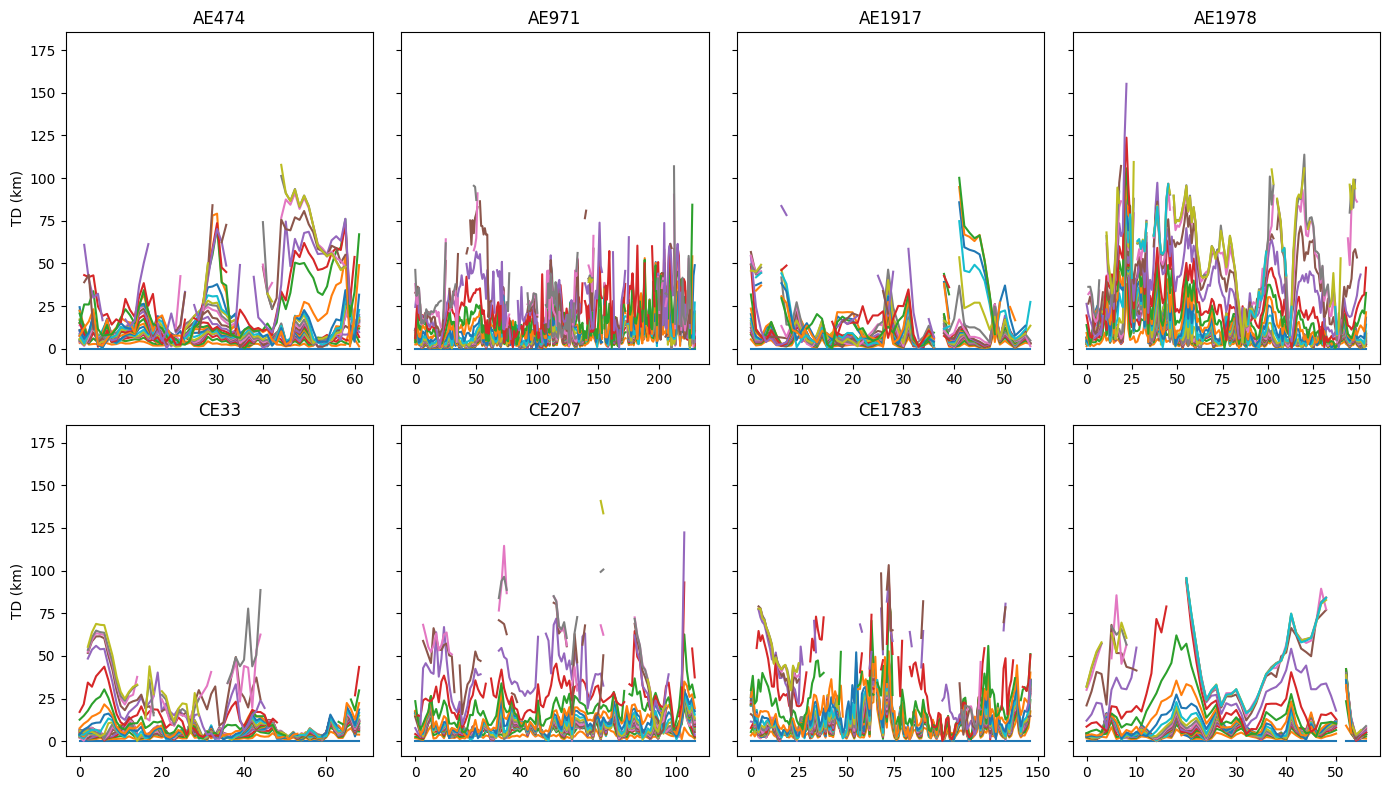

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(14,8), sharey=True)
# lvls = [11, 22, 24]
lvls = np.arange(len(z_r))
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    # df_sub = df.loc[:, df.columns.str.contains(f"Eddy{eddy}") | (df.columns == "Depth")]
    df_sub = df_depths_TD.loc[:, df_depths_TD.columns.str.contains(f'Eddy{eddy}')]
    for lvl in lvls:
        ax.plot(df_sub.iloc[lvl].values, label=round(-z_r[lvl]))
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
axs[0,0].set_ylabel('TD (km)')
axs[1,0].set_ylabel('TD (km)')
# axs[0,1].legend(ncol=2)
plt.tight_layout()


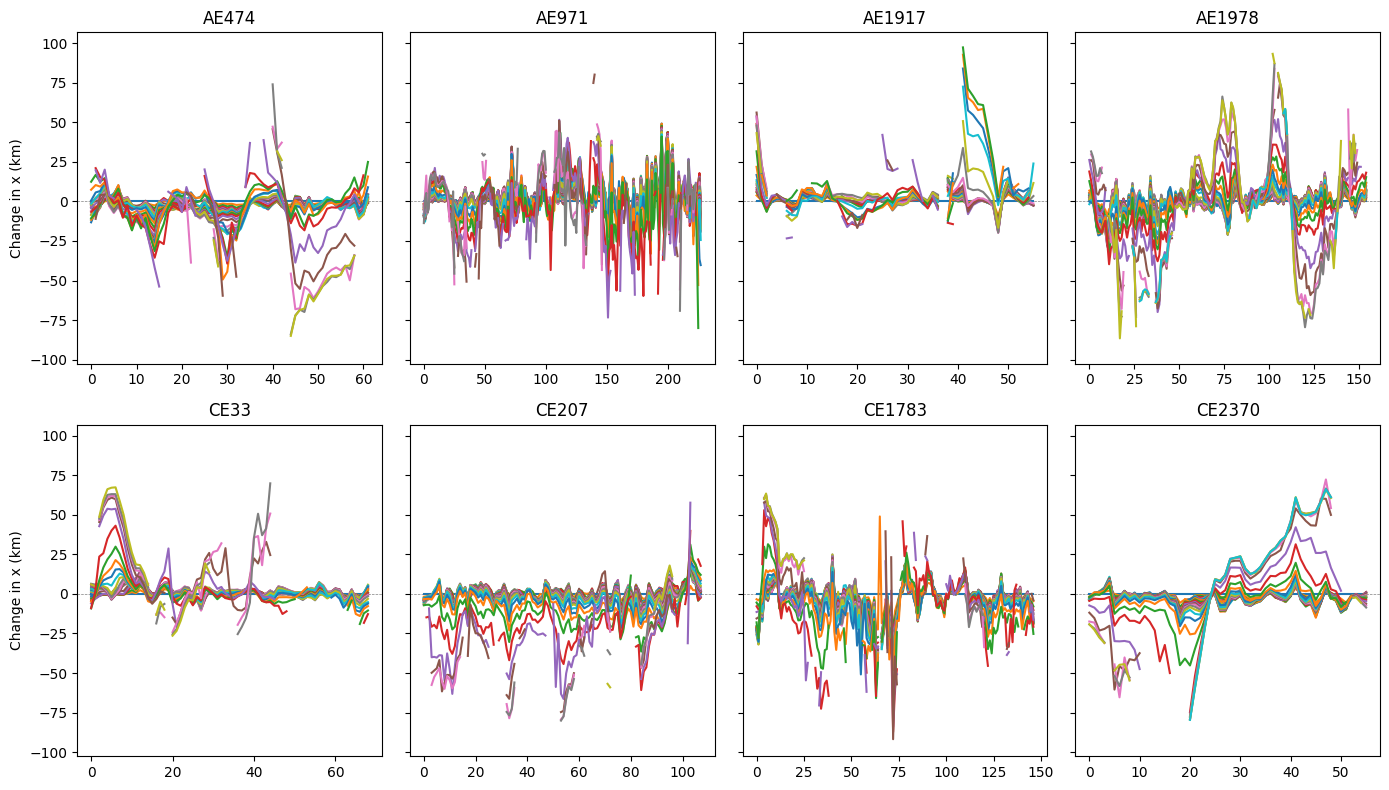

In [8]:
fig, axs = plt.subplots(2, 4, figsize=(14,8), sharey=True)
# lvls = [11, 22, 24]
lvls = np.arange(len(z_r))
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    ax.axhline(y=0, lw=.5, ls='--', color='k', alpha=.5)
    df_sub = df_depths.loc[:, df_depths.columns.str.contains(f'Eddy{eddy}_x')]
    for lvl in lvls:
        ax.plot(df_sub.iloc[lvl].values, label=round(-z_r[lvl]))
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
axs[0,0].set_ylabel('Change in x (km)')
axs[1,0].set_ylabel('Change in x (km)')
# axs[0,1].legend(ncol=2)
plt.tight_layout()

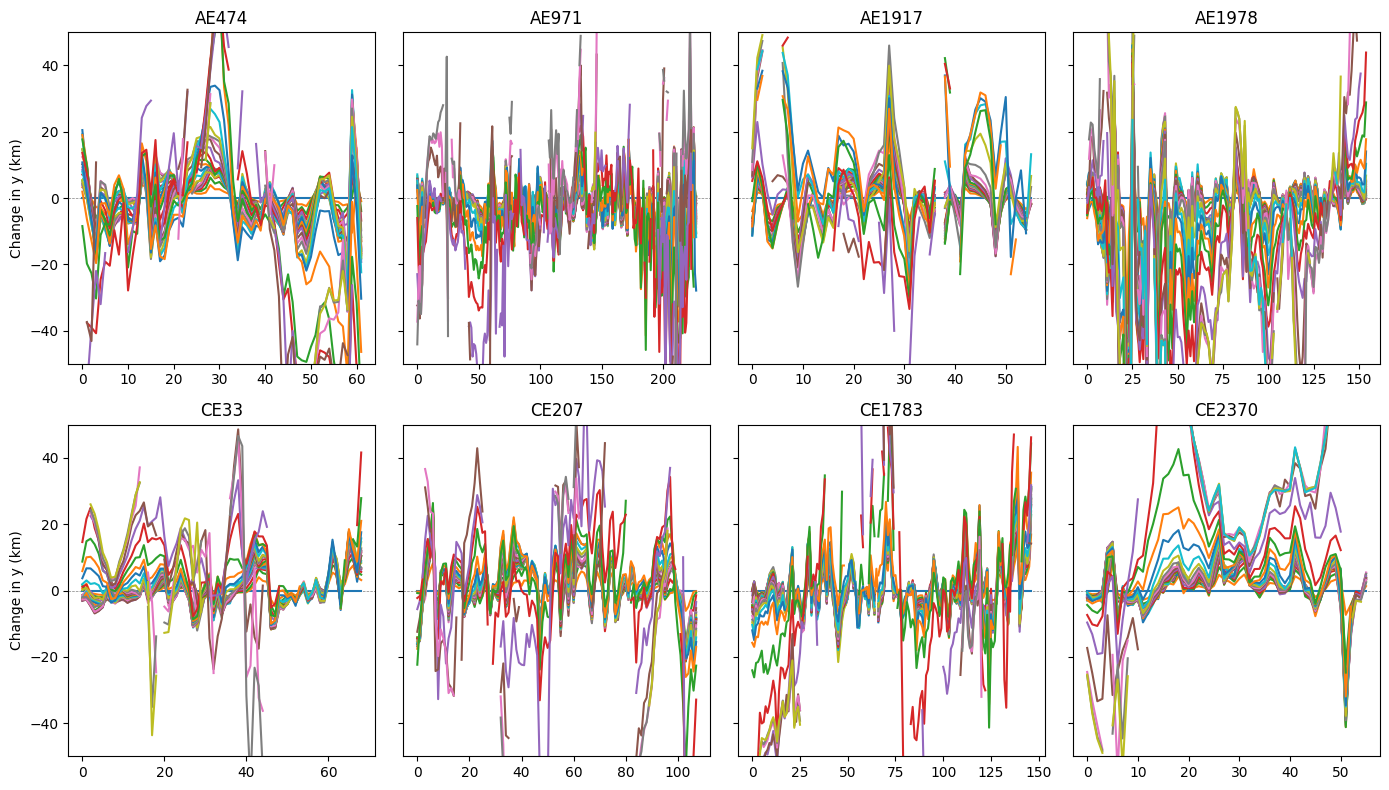

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(14,8), sharey=True)
lvls = [11, 22, 24]
lvls = np.arange(len(z_r))
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    ax.axhline(y=0, lw=.5, ls='--', color='k', alpha=.5)
    df_sub = df_depths.loc[:, df_depths.columns.str.contains(f'Eddy{eddy}_y')]
    for lvl in lvls:
        ax.plot(df_sub.iloc[lvl].values, label=round(-z_r[lvl]))
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    
axs[0,0].set_ylabel('Change in y (km)')
axs[1,0].set_ylabel('Change in y (km)')
axs[0,0].set_ylim(-50, 50)
# axs[0,1].legend(ncol=2)
plt.tight_layout()


### Li Tilt

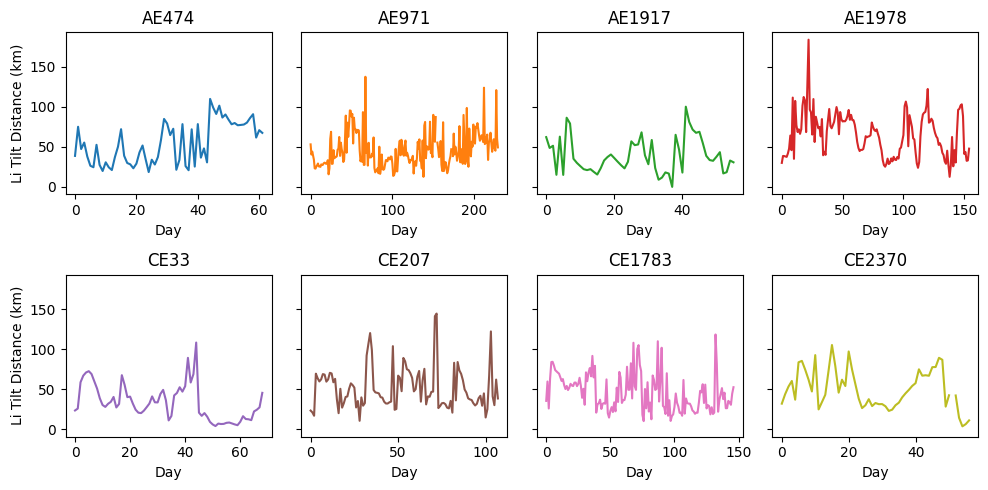

In [10]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)

for e, eddy in enumerate(dic_sample.keys()):
    ax = axs[e // 4, e % 4]
    dic = dic_sample[eddy]
    days = sorted(dic.keys())
    TDis = []
    for day in days:
        df = dic[day]
        if len(df):
            td, th, _ = tilt_distance_LI(df.x.values, df.y.values, -df.Depth.values)
            TDis.append(td)
        else:
            TDis.append(np.nan)
    ax.plot(range(len(TDis)), TDis, color=colors[e % 10])
    cyc = df_eddies[df_eddies.Eddy==int(eddy[4:])].iloc[0].Cyc
    ax.set_title(f'{cyc}{int(eddy[4:])}')
    ax.set_xlabel('Day')
axs[0,0].set_ylabel('Li Tilt Distance (km)')
axs[1,0].set_ylabel('Li Tilt Distance (km)')
plt.tight_layout()


### Regs Tilt

In [11]:
for e, eddy in enumerate(sample_eddies):
    dic = dic_eddies_vert[f'Eddy{eddy}']
    df = compute_tilt_data(dic, eddy)
    if e == 0:
        df_tilt_data = df
    else:
        df_tilt_data = pd.concat([df_tilt_data, df], ignore_index=True)
df_eddies = df_eddies.merge(
    df_tilt_data[['Eddy', 'Day', 'TiltDis', 'TiltDir']],
    how='left',
    left_on=['Eddy', 'Day'],
    right_on=['Eddy', 'Day']
)

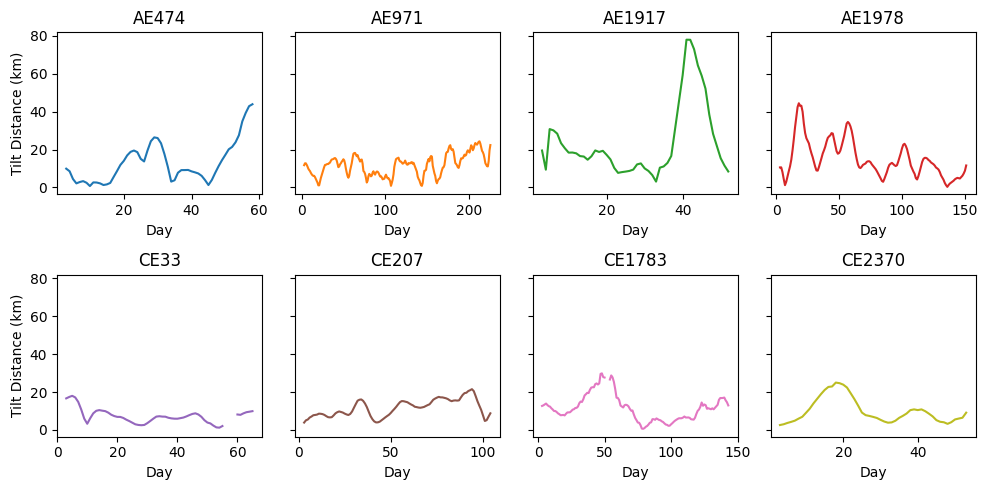

In [13]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)
for e, eddy in enumerate(sample_eddies):
    ax = axs[e // 4, e % 4]
    df = df_eddies[df_eddies.Eddy==eddy]
    ax.plot(np.arange(len(df)), df.TiltDis, color=colors[e])
    cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
    ax.set_title(f'{cyc}{eddy}')
    ax.set_xlabel('Day')
axs[0,0].set_ylabel('Tilt Distance (km)')
axs[1,0].set_ylabel('Tilt Distance (km)')
plt.tight_layout()


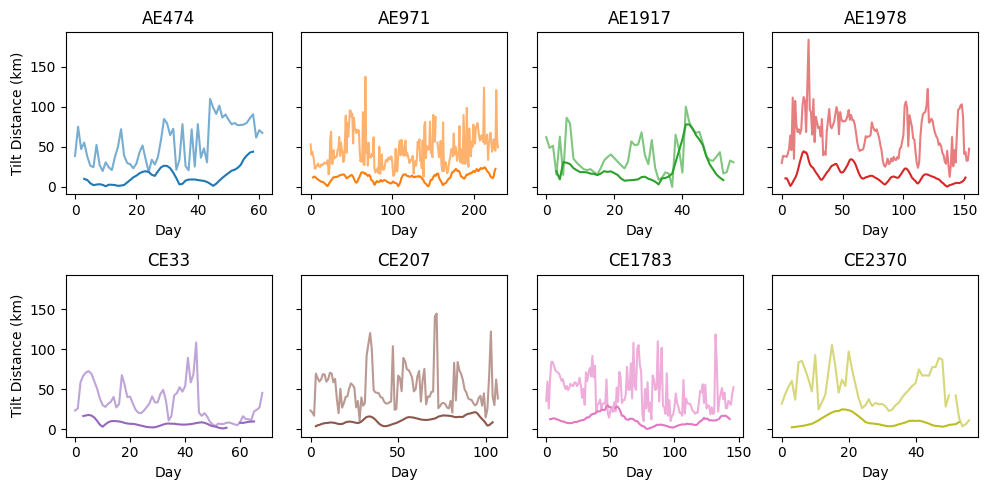

In [14]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)

for e, eddy in enumerate(dic_sample.keys()):
    ax = axs[e // 4, e % 4]
    dic = dic_sample[eddy]
    days = sorted(dic.keys())
    TDis = []
    for day in days:
        df = dic[day].copy()
        # df = df[df.Depth.abs() <=300]
        if len(df):
            td, th, _ = tilt_distance_LI(df.x.values, df.y.values, -df.Depth.values)
            TDis.append(td)
        else:
            TDis.append(np.nan)
    ax.plot(range(len(TDis)), TDis, color=colors[e % 10], alpha=.6)
    df = df_eddies[df_eddies.Eddy==int(eddy[4:])]
    ax.plot(np.arange(len(df)), df.TiltDis, color=colors[e])
    cyc = df_eddies[df_eddies.Eddy==int(eddy[4:])].iloc[0].Cyc
    ax.set_title(f'{cyc}{int(eddy[4:])}')
    ax.set_xlabel('Day')
axs[0,0].set_ylabel('Tilt Distance (km)')
axs[1,0].set_ylabel('Tilt Distance (km)')
plt.tight_layout()


#### My Tilt Breakdown

In [105]:
eddy = 2370
ref_day = 20
dic = dic_eddies_vert[f'Eddy{eddy}']
num = 6
depth_int = 10
max_depth = 1000

df_tilt_data = pd.DataFrame(columns=['Eddy', 'Day', 'TiltDis', 'TiltDir'])

diffs_x = {}
diffs_y = {}
df_x_interp = {}
df_y_interp = {}
    
for d, day in enumerate(dic.keys()):

    df = dic[day].copy()
    df['Depth'] = -df['Depth']
    df = df[df['Depth'] <= max_depth]
    # don’t drop rows — keep all depths, even if x or y are NaN
    df = df.set_index('Depth').sort_index()

    if len(df):
        depths = df.index.values
        # interpolate at every 10 m from 0 to max_depth
        target_depths = np.arange(0, max_depth+1, depth_int)
        valid = target_depths[
            (target_depths >= depths.min()) &
            (target_depths <= depths.max())
        ]
        if len(valid) < 2:
            continue
    
        x_i = np.interp(valid, depths, df['x'].values, left=np.nan, right=np.nan)
        y_i = np.interp(valid, depths, df['y'].values, left=np.nan, right=np.nan)

        df_x_interp[f'$t_{{{d}}}$'] = pd.Series(x_i, index=valid)
        df_y_interp[f'$t_{{{d}}}$'] = pd.Series(y_i, index=valid)
    
        dx = np.diff(x_i)
        dy = np.diff(y_i)
    
        # use the actual depth levels (valid[:-1]) as the Series index
        idx = valid[:-1]
        diffs_x[f'$t_{{{d}}}$'] = pd.Series(dx, index=idx)
        diffs_y[f'$t_{{{d}}}$'] = pd.Series(dy, index=idx)

    else:
        idx = [depth_int]
        diffs_x[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
        diffs_y[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)

        df_x_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
        df_y_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
        
# now construct your DataFrames simply by passing the dict-of-series:
df_X_all = pd.DataFrame(diffs_x)
df_Y_all = pd.DataFrame(diffs_y)

df_x_interp_all = pd.DataFrame(df_x_interp)
df_y_interp_all = pd.DataFrame(df_y_interp)

# for ref_day in range(num //2, len(dic) - num //2):
for ref_day in [ref_day]:

    df_X = df_X_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    df_Y = df_Y_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]

    df_x_interp = df_x_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    df_y_interp = df_y_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    
    # Calculation of variability at each depth
    df_data = pd.DataFrame()
    df_data[r'$\Delta x$'] = df_X.mean(axis=1)
    df_data[r'$\Delta y$'] = df_Y.mean(axis=1)
    df_data[r'$\sum{\Delta x}$'] = df_data[r'$\Delta x$'].cumsum()
    df_data[r'$\sum{\Delta y}$'] = df_data[r'$\Delta y$'].cumsum()
    df_data[r'$\sigma^2_{\Delta x}$'] = df_X.var(axis=1)
    df_data[r'$\sigma^2_{\Delta y}$'] = df_Y.var(axis=1)
    df_data[r'Total $\sigma^2$'] = df_data[r'$\sigma^2_{\Delta x}$'] + df_data[r'$\sigma^2_{\Delta y}$']
    df_data['weight'] = 1 / df_data[r'Total $\sigma^2$']
    df_data['Depth'] = df_data.index 
    df_data
    
    # Line of Best Fit
    
    # your data arrays of shape (N,)
    x = df_data[r'$\sum{\Delta x}$'].values
    y = df_data[r'$\sum{\Delta y}$'].values
    z = df_data['Depth'].values
    w = df_data['weight'].values
    
    # 1. compute weighted mean
    W = np.sum(w)
    mean = np.array([np.dot(w, x),
                     np.dot(w, y),
                     np.dot(w, z)]) / W
    
    # 2. center and weight the data
    X = np.vstack((x, y, z)).T
    Xc = X - mean
    Xw = Xc * np.sqrt(w)[:, None]
    
    # 3. SVD on weighted, centered data
    try:
        flag = 0
        _, _, Vt = np.linalg.svd(Xw, full_matrices=False)
    except Exception:
        flag = 1
        # print(f"Eddy{eddy} on day {list(dic.keys())[ref_day][3:]} did not have a measurable profile")
        
    if flag:
        
        df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': ref_day, 'TiltDis': np.nan, 'TiltDir': np.nan}
        
    else:
        
        direction = Vt[0]   # principal axis
        
        # The best-fit line is:  p(t) = mean + t * direction
        t = np.linspace((np.max(z)-mean[2])/direction[2], (np.min(z)-mean[2])/direction[2], 2)            # shape (100,)
        p = mean[None, :] + t[:, None] * direction  # shape (100,3)
        # or equivalently
        p = mean + np.outer(t, direction)          # also (100,3)
        
        # then split back out if you need x,y,z separately:
        x_line, y_line, z_line = p.T
        
        tilt_dist = np.hypot(x_line[0]-x_line[1], y_line[0]-y_line[1])
        
        top_idx = np.where(np.abs(z_line)==np.min(np.abs(z_line)))[0][0]
        if top_idx == 1:
            btm_idx = 0
        else:
            btm_idx = 1
        top = [x_line[top_idx], y_line[top_idx], z_line[top_idx]]
        btm = [x_line[btm_idx], y_line[btm_idx], z_line[btm_idx]]
        tilt_direc = ( bearing(btm, top) + 20 ) % 360
    
        df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': ref_day, 'TiltDis': tilt_dist, 'TiltDir': tilt_direc}
    
df_tilt_data['Day'] = df_tilt_data['Day'].astype(int)
df_tilt_data


,Eddy,Day,TiltDis,TiltDir
0,2370,20,23.923635,165.278561


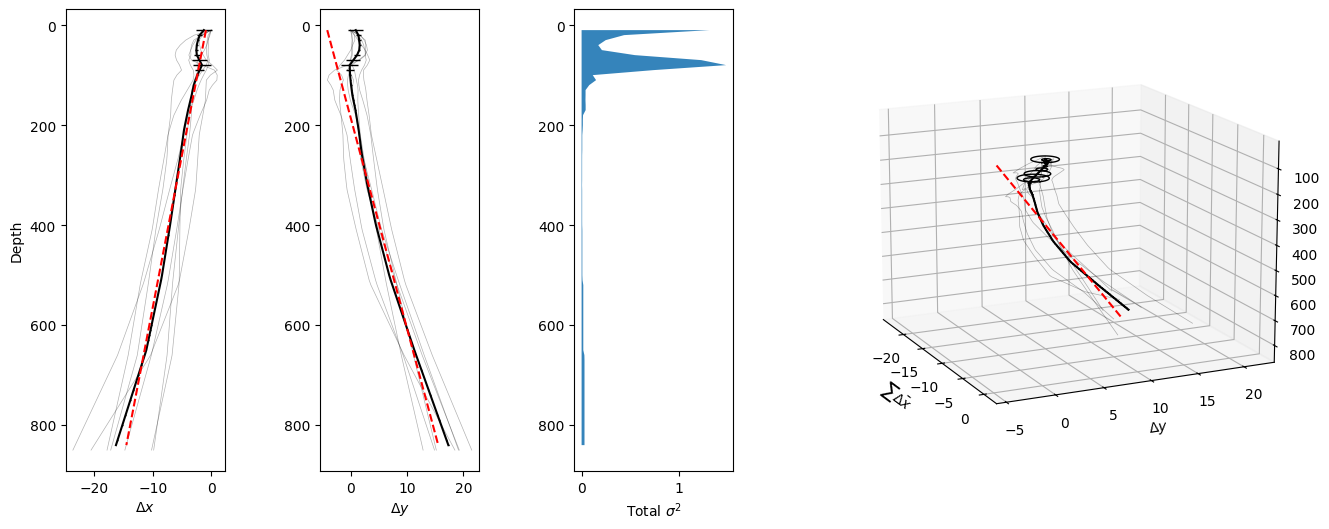

In [103]:
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(16, 6))  # wider figure
gs = fig.add_gridspec(1, 4, width_ratios=[1, 1, 1, 3], wspace=0.4)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1], sharey=ax0)
ax2 = fig.add_subplot(gs[0, 2], sharey=ax0)
ax3 = fig.add_subplot(gs[0, 3], projection='3d')

y = df_x_interp.index.to_numpy()

for t in range(df_x_interp.shape[1]):
    xt = (df_x_interp.iloc[:, t] - df_x_interp.iloc[0, t]).to_numpy()
    yt = (df_y_interp.iloc[:, t] - df_y_interp.iloc[0, t]).to_numpy()
    ax0.plot(xt, y, alpha=.3, color='k', lw=.5)
    ax1.plot(yt, y, alpha=.3, color='k', lw=.5)
    ax3.plot(xt, yt, y, alpha=.3, color='k', lw=.5)
    if t == 3:
        xmu = df_data[r'$\sum{\Delta x}$'].to_numpy()
        ymu = df_data[r'$\sum{\Delta y}$'].to_numpy()
        d   = df_data['Depth'].to_numpy()
        tvar = df_data[r'Total $\sigma^2$'].to_numpy()

        ax0.plot(xmu, d, 'k')
        ax1.plot(ymu, d, 'k')
        ax3.plot(xmu, ymu, d, 'k')

        ax0.hlines(d, xmu - tvar, xmu + tvar, color='k', lw=1)
        ax1.hlines(d, ymu - tvar, ymu + tvar, color='k', lw=1)

        theta = np.linspace(0, 2*np.pi, 100)
        for xm, ym, dm, rv in zip(xmu, ymu, d, tvar):
            cx = xm + rv*np.cos(theta)
            cy = ym + rv*np.sin(theta)
            cz = np.full_like(cx, dm)
            ax3.plot(cx, cy, cz, color='k', lw=1)

ax0.plot([top[0], btm[0]], [top[2], btm[2]], color='r', ls='--')
ax1.plot([top[1], btm[1]], [top[2], btm[2]], color='r', ls='--')
ax3.plot([top[0], btm[0]], [top[1], btm[1]], [top[2], btm[2]], color='r', ls='--')

ax0.invert_yaxis()
ax1.invert_yaxis()
ax2.invert_yaxis()
ax3.invert_zaxis()

ax2.fill_betweenx(df_data['Depth'], 0, df_data[r'Total $\sigma^2$'], alpha=0.9)

ax0.set_xlabel(r'$\Delta x$'); ax0.set_ylabel('Depth')
ax1.set_xlabel(r'$\Delta y$')
ax2.set_xlabel(r'Total $\sigma^2$')
ax3.set_xlabel(r'$\sum\bar{\Delta x}$'); ax3.set_ylabel(r'$\Delta y$'); ax3.set_zlabel('Depth 9km)')
ax3.view_init(elev=15, azim=-25)

# plt.tight_layout()
plt.show()



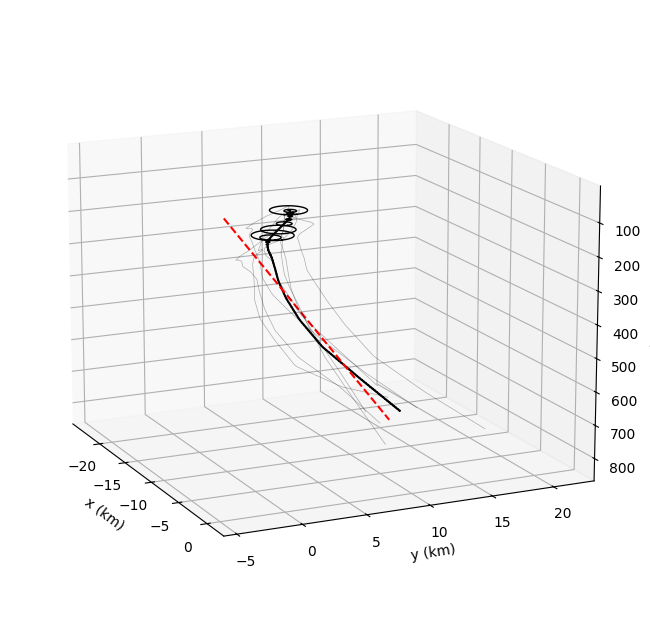

In [107]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

fig = plt.figure(figsize=(12, 8))   # big standalone 3D figure
ax3 = fig.add_subplot(111, projection='3d')

y = df_x_interp.index.to_numpy()

for t in range(df_x_interp.shape[1]):
    xt = (df_x_interp.iloc[:, t] - df_x_interp.iloc[0, t]).to_numpy()
    yt = (df_y_interp.iloc[:, t] - df_y_interp.iloc[0, t]).to_numpy()
    ax3.plot(xt, yt, y, alpha=.3, color='k', lw=.5)
    if t == 3:
        xmu = df_data[r'$\sum{\Delta x}$'].to_numpy()
        ymu = df_data[r'$\sum{\Delta y}$'].to_numpy()
        d   = df_data['Depth'].to_numpy()
        tvar = df_data[r'Total $\sigma^2$'].to_numpy()

        ax3.plot(xmu, ymu, d, 'k')

        theta = np.linspace(0, 2*np.pi, 100)
        for xm, ym, dm, rv in zip(xmu, ymu, d, tvar):
            cx = xm + rv*np.cos(theta)
            cy = ym + rv*np.sin(theta)
            cz = np.full_like(cx, dm)
            ax3.plot(cx, cy, cz, color='k', lw=1)

        ax3.plot([top[0], btm[0]], [top[1], btm[1]], [top[2], btm[2]], color='r', ls='--')

ax3.invert_zaxis()

ax3.set_xlabel('x (km)')
ax3.set_ylabel('y (km)')
ax3.set_zlabel('Depth (km)')

ax3.view_init(elev=15, azim=-25)

plt.show()


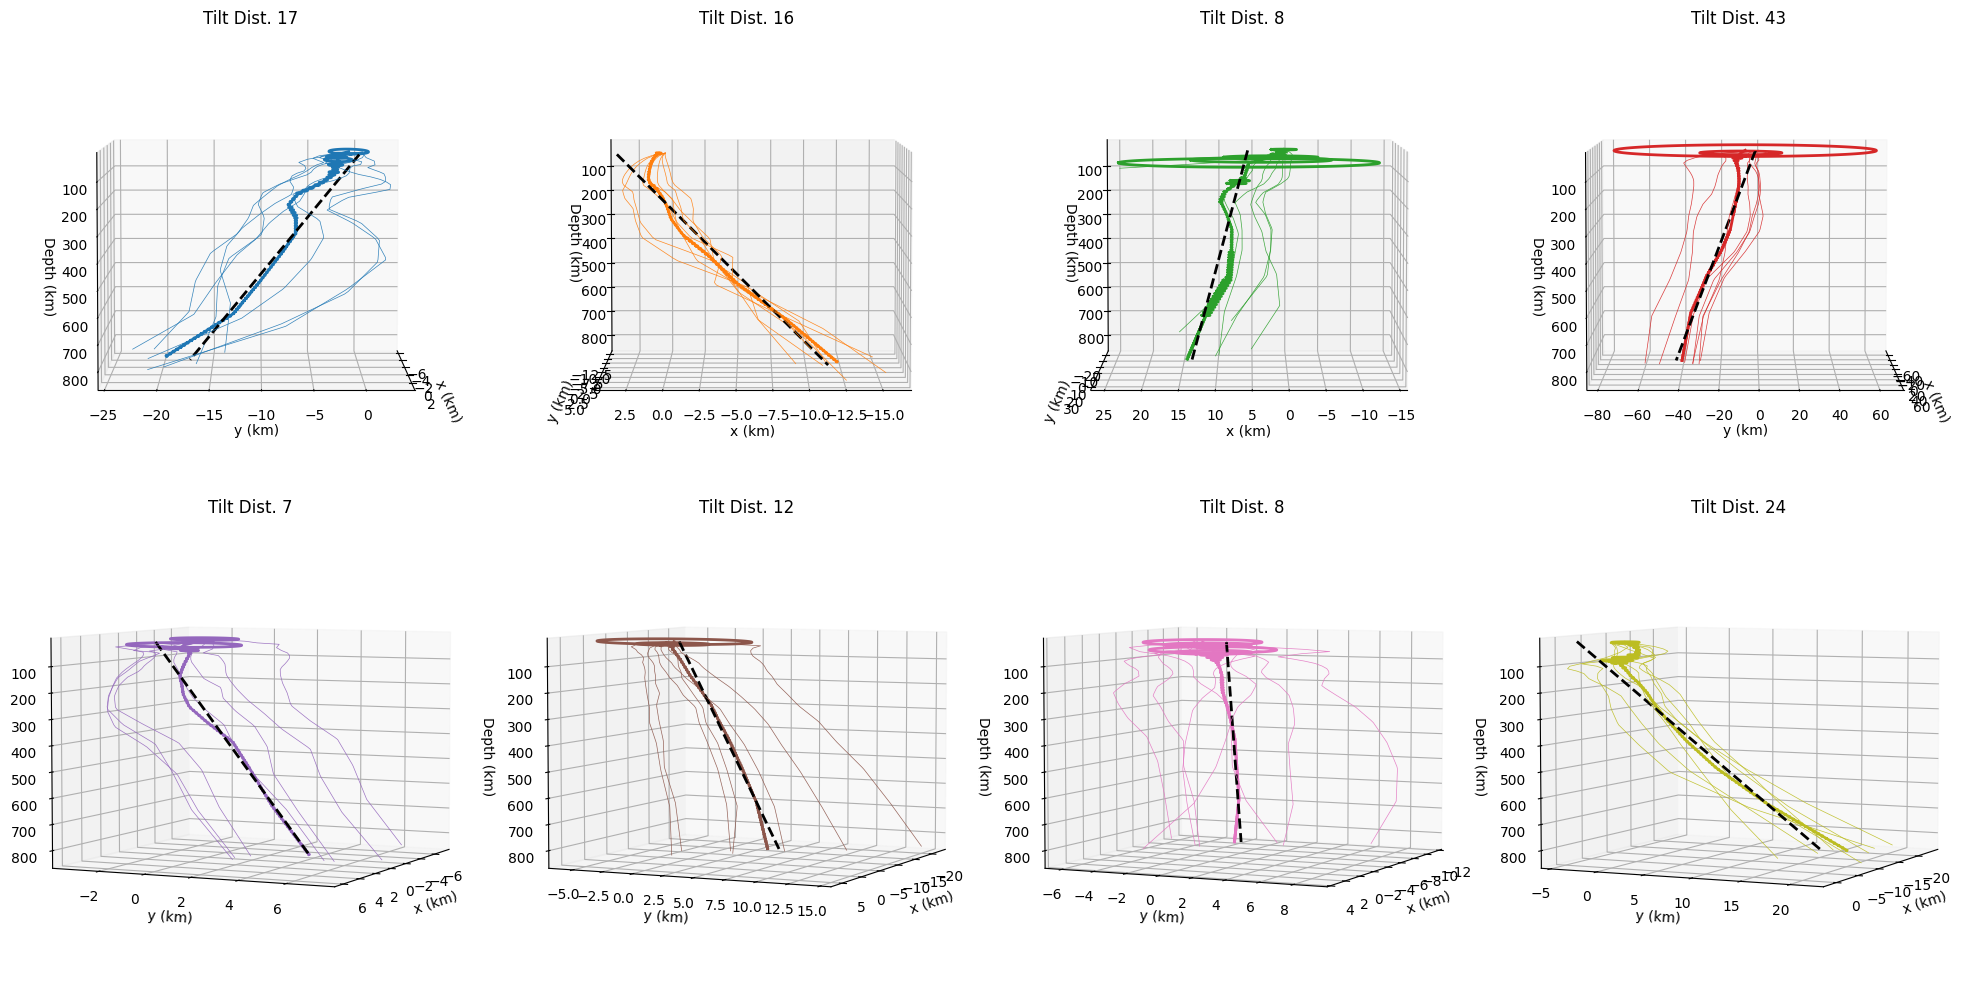

In [144]:
from mpl_toolkits.mplot3d import Axes3D 

# Create a 2x4 grid of 3D subplots
fig = plt.figure(figsize=(20, 10))  # make it wide and tall enough
axes = []

ref_days = [50, 40, 52, 20, 
            20, 30, 20, 20]
azims = [0, 90, 90, 0,
         25, 25, 25, 25]

for e, (eddy, ref_day) in enumerate(zip(sample_eddies, ref_days)):
    dic = dic_eddies_vert[f'Eddy{eddy}']
    num = 6
    depth_int = 10
    max_depth = 1000
    
    df_tilt_data = pd.DataFrame(columns=['Eddy', 'Day', 'TiltDis', 'TiltDir'])
    
    diffs_x = {}
    diffs_y = {}
    df_x_interp = {}
    df_y_interp = {}
        
    for d, day in enumerate(dic.keys()):
    
        df = dic[day].copy()
        df['Depth'] = -df['Depth']
        df = df[df['Depth'] <= max_depth]
        # don’t drop rows — keep all depths, even if x or y are NaN
        df = df.set_index('Depth').sort_index()
    
        if len(df):
            depths = df.index.values
            # interpolate at every 10 m from 0 to max_depth
            target_depths = np.arange(0, max_depth+1, depth_int)
            valid = target_depths[
                (target_depths >= depths.min()) &
                (target_depths <= depths.max())
            ]
            if len(valid) < 2:
                continue
        
            x_i = np.interp(valid, depths, df['x'].values, left=np.nan, right=np.nan)
            y_i = np.interp(valid, depths, df['y'].values, left=np.nan, right=np.nan)
    
            df_x_interp[f'$t_{{{d}}}$'] = pd.Series(x_i, index=valid)
            df_y_interp[f'$t_{{{d}}}$'] = pd.Series(y_i, index=valid)
        
            dx = np.diff(x_i)
            dy = np.diff(y_i)
        
            # use the actual depth levels (valid[:-1]) as the Series index
            idx = valid[:-1]
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(dx, index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(dy, index=idx)
    
        else:
            idx = [depth_int]
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
    
            df_x_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            df_y_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            
    # now construct your DataFrames simply by passing the dict-of-series:
    df_X_all = pd.DataFrame(diffs_x)
    df_Y_all = pd.DataFrame(diffs_y)
    
    df_x_interp_all = pd.DataFrame(df_x_interp)
    df_y_interp_all = pd.DataFrame(df_y_interp)
    
    df_X = df_X_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    df_Y = df_Y_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    
    df_x_interp = df_x_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    df_y_interp = df_y_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    
    # Calculation of variability at each depth
    df_data = pd.DataFrame()
    df_data[r'$\Delta x$'] = df_X.mean(axis=1)
    df_data[r'$\Delta y$'] = df_Y.mean(axis=1)
    df_data[r'$\sum{\Delta x}$'] = df_data[r'$\Delta x$'].cumsum()
    df_data[r'$\sum{\Delta y}$'] = df_data[r'$\Delta y$'].cumsum()
    df_data[r'$\sigma^2_{\Delta x}$'] = df_X.var(axis=1)
    df_data[r'$\sigma^2_{\Delta y}$'] = df_Y.var(axis=1)
    df_data[r'Total $\sigma^2$'] = df_data[r'$\sigma^2_{\Delta x}$'] + df_data[r'$\sigma^2_{\Delta y}$']
    df_data['weight'] = 1 / df_data[r'Total $\sigma^2$']
    df_data['Depth'] = df_data.index 
    df_data
    
    # Line of Best Fit
    
    # your data arrays of shape (N,)
    x = df_data[r'$\sum{\Delta x}$'].values
    y = df_data[r'$\sum{\Delta y}$'].values
    z = df_data['Depth'].values
    w = df_data['weight'].values
    
    # 1. compute weighted mean
    W = np.sum(w)
    mean = np.array([np.dot(w, x),
                     np.dot(w, y),
                     np.dot(w, z)]) / W
    
    # 2. center and weight the data
    X = np.vstack((x, y, z)).T
    Xc = X - mean
    Xw = Xc * np.sqrt(w)[:, None]
    
    # 3. SVD on weighted, centered data
    try:
        flag = 0
        _, _, Vt = np.linalg.svd(Xw, full_matrices=False)
    except Exception:
        flag = 1
        # print(f"Eddy{eddy} on day {list(dic.keys())[ref_day][3:]} did not have a measurable profile")
        
    if flag:
        
        df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': ref_day, 'TiltDis': np.nan, 'TiltDir': np.nan}
        
    else:
        
        direction = Vt[0]   # principal axis
        
        # The best-fit line is:  p(t) = mean + t * direction
        t = np.linspace((np.max(z)-mean[2])/direction[2], (np.min(z)-mean[2])/direction[2], 2)            # shape (100,)
        p = mean[None, :] + t[:, None] * direction  # shape (100,3)
        # or equivalently
        p = mean + np.outer(t, direction)          # also (100,3)
        
        # then split back out if you need x,y,z separately:
        x_line, y_line, z_line = p.T
        
        tilt_dist = np.hypot(x_line[0]-x_line[1], y_line[0]-y_line[1])
        
        top_idx = np.where(np.abs(z_line)==np.min(np.abs(z_line)))[0][0]
        if top_idx == 1:
            btm_idx = 0
        else:
            btm_idx = 1
        top = [x_line[top_idx], y_line[top_idx], z_line[top_idx]]
        btm = [x_line[btm_idx], y_line[btm_idx], z_line[btm_idx]]
        tilt_direc = ( bearing(btm, top) + 20 ) % 360
    
        df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': ref_day, 'TiltDis': tilt_dist, 'TiltDir': tilt_direc}

        ax = fig.add_subplot(2, 4, e+1, projection='3d')
        axes.append(ax)

        y = df_x_interp.index.to_numpy()
        
        for t in range(df_x_interp.shape[1]):
            xt = (df_x_interp.iloc[:, t] - df_x_interp.iloc[0, t]).to_numpy()
            yt = (df_y_interp.iloc[:, t] - df_y_interp.iloc[0, t]).to_numpy()
            ax.plot(xt, yt, y, alpha=.9, lw=.5, color=colors[e])
            if t == 3:
                xmu = df_data[r'$\sum{\Delta x}$'].to_numpy()
                ymu = df_data[r'$\sum{\Delta y}$'].to_numpy()
                d   = df_data['Depth'].to_numpy()
                tvar = df_data[r'Total $\sigma^2$'].to_numpy()
        
                ax.plot(xmu, ymu, d, color=colors[e], lw=2)
        
                theta = np.linspace(0, 2*np.pi, 100)
                for xm, ym, dm, rv in zip(xmu, ymu, d, tvar):
                    cx = xm + rv*np.cos(theta)
                    cy = ym + rv*np.sin(theta)
                    cz = np.full_like(cx, dm)
                    ax.plot(cx, cy, cz, lw=2, color=colors[e])
        
                ax.plot([top[0], btm[0]], [top[1], btm[1]], [top[2], btm[2]], color='k', ls='--', lw=2)
        
        ax.invert_zaxis()
        
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
        ax.set_zlabel('Depth (km)')
        
        ax.view_init(elev=5, azim=azims[e])
        ax.set_title(f'Tilt Dist. {round(tilt_dist)}')
    
plt.tight_layout()
plt.show()


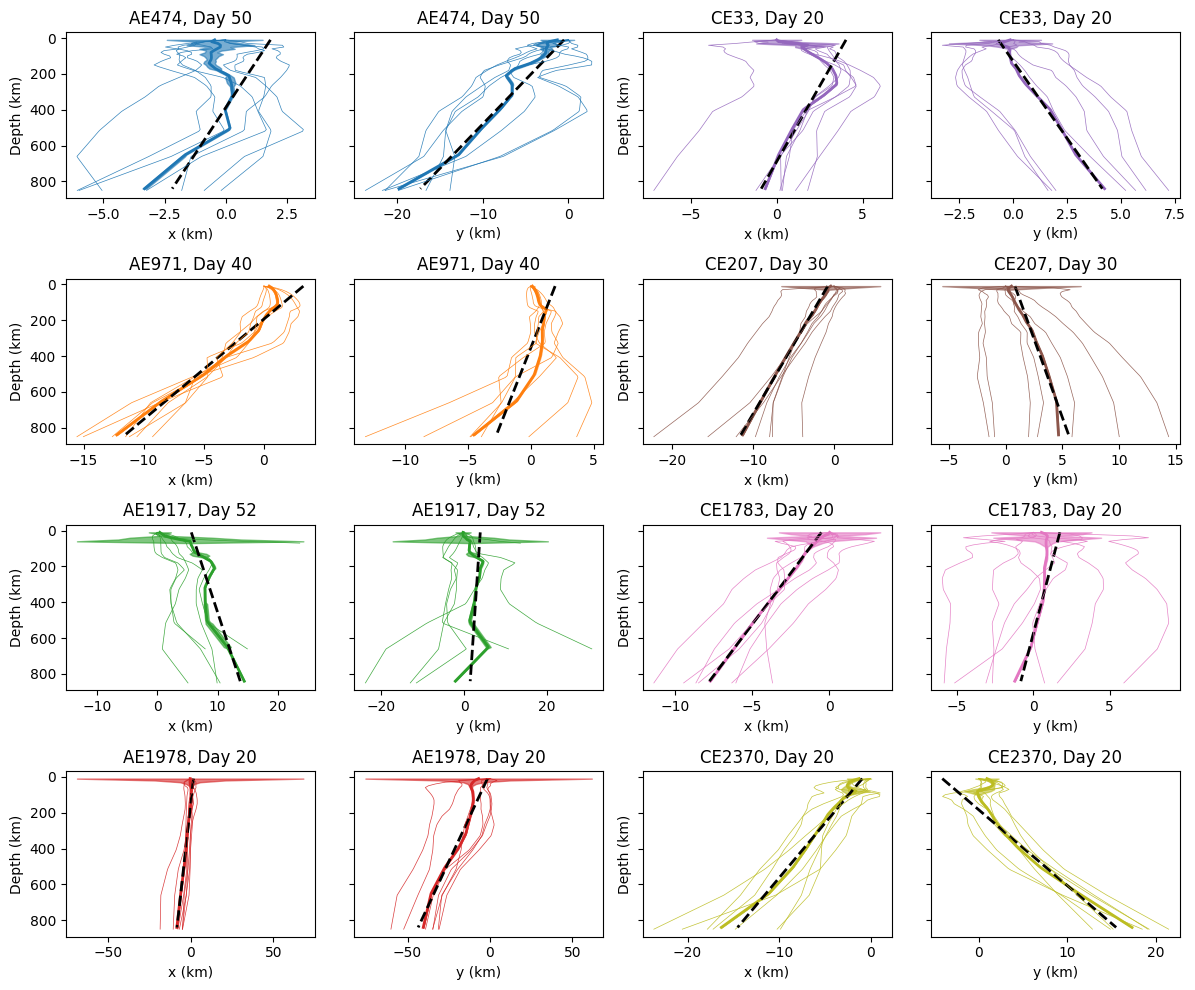

In [156]:
fig, axs = plt.subplots(4, 4, figsize=(12,10), sharey=True)

ref_days = [50, 40, 52, 20, 
            20, 30, 20, 20]
for e, (eddy, ref_day) in enumerate(zip(sample_eddies, ref_days)):
    ax0 = axs[e % 4, (e//4)*2]
    ax1 = axs[e % 4, 1+(e//4)*2]
    
    dic = dic_eddies_vert[f'Eddy{eddy}']
    num = 6
    depth_int = 10
    max_depth = 1000
    
    df_tilt_data = pd.DataFrame(columns=['Eddy', 'Day', 'TiltDis', 'TiltDir'])
    
    diffs_x = {}
    diffs_y = {}
    df_x_interp = {}
    df_y_interp = {}
        
    for d, day in enumerate(dic.keys()):
    
        df = dic[day].copy()
        df['Depth'] = -df['Depth']
        df = df[df['Depth'] <= max_depth]
        # don’t drop rows — keep all depths, even if x or y are NaN
        df = df.set_index('Depth').sort_index()
    
        if len(df):
            depths = df.index.values
            # interpolate at every 10 m from 0 to max_depth
            target_depths = np.arange(0, max_depth+1, depth_int)
            valid = target_depths[
                (target_depths >= depths.min()) &
                (target_depths <= depths.max())
            ]
            if len(valid) < 2:
                continue
        
            x_i = np.interp(valid, depths, df['x'].values, left=np.nan, right=np.nan)
            y_i = np.interp(valid, depths, df['y'].values, left=np.nan, right=np.nan)
    
            df_x_interp[f'$t_{{{d}}}$'] = pd.Series(x_i, index=valid)
            df_y_interp[f'$t_{{{d}}}$'] = pd.Series(y_i, index=valid)
        
            dx = np.diff(x_i)
            dy = np.diff(y_i)
        
            # use the actual depth levels (valid[:-1]) as the Series index
            idx = valid[:-1]
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(dx, index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(dy, index=idx)
    
        else:
            idx = [depth_int]
            diffs_x[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            diffs_y[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
    
            df_x_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            df_y_interp[f'$t_{{{d}}}$'] = pd.Series(np.array([np.nan]*len(idx)), index=idx)
            
    # now construct your DataFrames simply by passing the dict-of-series:
    df_X_all = pd.DataFrame(diffs_x)
    df_Y_all = pd.DataFrame(diffs_y)
    
    df_x_interp_all = pd.DataFrame(df_x_interp)
    df_y_interp_all = pd.DataFrame(df_y_interp)
    
    df_X = df_X_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    df_Y = df_Y_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    
    df_x_interp = df_x_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    df_y_interp = df_y_interp_all.iloc[:, ref_day - num // 2:ref_day + num // 2 + 1]
    
    # Calculation of variability at each depth
    df_data = pd.DataFrame()
    df_data[r'$\Delta x$'] = df_X.mean(axis=1)
    df_data[r'$\Delta y$'] = df_Y.mean(axis=1)
    df_data[r'$\sum{\Delta x}$'] = df_data[r'$\Delta x$'].cumsum()
    df_data[r'$\sum{\Delta y}$'] = df_data[r'$\Delta y$'].cumsum()
    df_data[r'$\sigma^2_{\Delta x}$'] = df_X.var(axis=1)
    df_data[r'$\sigma^2_{\Delta y}$'] = df_Y.var(axis=1)
    df_data[r'Total $\sigma^2$'] = df_data[r'$\sigma^2_{\Delta x}$'] + df_data[r'$\sigma^2_{\Delta y}$']
    df_data['weight'] = 1 / df_data[r'Total $\sigma^2$']
    df_data['Depth'] = df_data.index 
    df_data
    
    # Line of Best Fit
    
    # your data arrays of shape (N,)
    x = df_data[r'$\sum{\Delta x}$'].values
    y = df_data[r'$\sum{\Delta y}$'].values
    z = df_data['Depth'].values
    w = df_data['weight'].values
    
    # 1. compute weighted mean
    W = np.sum(w)
    mean = np.array([np.dot(w, x),
                     np.dot(w, y),
                     np.dot(w, z)]) / W
    
    # 2. center and weight the data
    X = np.vstack((x, y, z)).T
    Xc = X - mean
    Xw = Xc * np.sqrt(w)[:, None]
    
    # 3. SVD on weighted, centered data
    try:
        flag = 0
        _, _, Vt = np.linalg.svd(Xw, full_matrices=False)
    except Exception:
        flag = 1
        # print(f"Eddy{eddy} on day {list(dic.keys())[ref_day][3:]} did not have a measurable profile")
        
    if flag:
        
        df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': ref_day, 'TiltDis': np.nan, 'TiltDir': np.nan}
        
    else:
        
        direction = Vt[0]   # principal axis
        
        # The best-fit line is:  p(t) = mean + t * direction
        t = np.linspace((np.max(z)-mean[2])/direction[2], (np.min(z)-mean[2])/direction[2], 2)            # shape (100,)
        p = mean[None, :] + t[:, None] * direction  # shape (100,3)
        # or equivalently
        p = mean + np.outer(t, direction)          # also (100,3)
        
        # then split back out if you need x,y,z separately:
        x_line, y_line, z_line = p.T
        
        tilt_dist = np.hypot(x_line[0]-x_line[1], y_line[0]-y_line[1])
        
        top_idx = np.where(np.abs(z_line)==np.min(np.abs(z_line)))[0][0]
        if top_idx == 1:
            btm_idx = 0
        else:
            btm_idx = 1
        top = [x_line[top_idx], y_line[top_idx], z_line[top_idx]]
        btm = [x_line[btm_idx], y_line[btm_idx], z_line[btm_idx]]
        tilt_direc = ( bearing(btm, top) + 20 ) % 360
    
        df_tilt_data.loc[len(df_tilt_data)] = {'Eddy': eddy, 'Day': ref_day, 'TiltDis': tilt_dist, 'TiltDir': tilt_direc}

        # PLOT

        y = df_x_interp.index.to_numpy()
        
        for t in range(df_x_interp.shape[1]):
            xt = (df_x_interp.iloc[:, t] - df_x_interp.iloc[0, t]).to_numpy()
            yt = (df_y_interp.iloc[:, t] - df_y_interp.iloc[0, t]).to_numpy()
            
            ax0.plot(xt, y, alpha=.9, lw=.5, color=colors[e])
            ax1.plot(yt, y, alpha=.9, lw=.5, color=colors[e])

            if t == 3:
                xmu = df_data[r'$\sum{\Delta x}$'].to_numpy()
                ymu = df_data[r'$\sum{\Delta y}$'].to_numpy()
                d   = df_data['Depth'].to_numpy()
                tvar = df_data[r'Total $\sigma^2$'].to_numpy()
        
                theta = np.linspace(0, 2*np.pi, 100)
                cx_mins, cx_maxs, cy_mins, cy_maxs = [], [], [], []
                for xm, ym, dm, rv in zip(xmu, ymu, d, tvar):
                    cx = xm + rv*np.cos(theta)
                    cy = ym + rv*np.sin(theta)
                    cz = np.full_like(cx, dm)

                    cx_mins.append(cx.min())
                    cx_maxs.append(cx.max())
                    cy_mins.append(cy.min())
                    cy_maxs.append(cy.max())
                    
                    # ax0.plot(cx, cz, lw=2, color=colors[e])
                    # ax1.plot(cy, cz, lw=2, color=colors[e])
                ax0.fill_betweenx(d, cx_mins, cx_maxs, color=colors[e], alpha=0.6)
                ax1.fill_betweenx(d, cy_mins, cy_maxs, color=colors[e], alpha=0.6)

                ax0.plot(xmu, d, color=colors[e], lw=2)
                ax1.plot(ymu, d, color=colors[e], lw=2)

                ax0.plot([top[0], btm[0]], [top[2], btm[2]], color='k', ls='--', lw=2)
                ax1.plot([top[1], btm[1]], [top[2], btm[2]], color='k', ls='--', lw=2)

        ax0.set_xlabel('x (km)')
        ax1.set_xlabel('y (km)')
        ax0.set_ylabel('Depth (km)')

        cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
        ax0.set_title(f'{cyc}{eddy}, Day {ref_day}')
        ax1.set_title(f'{cyc}{eddy}, Day {ref_day}')

        # ax0.set_xlim(-50, 50)
        # ax1.set_xlim(-50, 50)

axs[0,0].invert_yaxis()
plt.tight_layout()
plt.show()


In [15]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
def point_b(a, r, theta_deg):
    theta_rad = np.radians(theta_deg)
    dx = r * np.cos(theta_rad)
    dy = r * np.sin(theta_rad)
    return a[0] + dx, a[1] + dy

def km_to_deg(km, lat, bearing_deg):
    lat_rad = np.radians(lat)
    bearing_rad = np.radians(bearing_deg)

    # km per degree
    km_per_deg_lat = 111.32
    km_per_deg_lon = 111.32 * np.cos(lat_rad)

    # project distance onto lat/lon directions
    dlat = km * np.sin(bearing_rad) / km_per_deg_lat
    dlon = km * np.cos(bearing_rad) / km_per_deg_lon

    # total angular distance in degrees
    return np.hypot(dlat, dlon)

from matplotlib.colors import to_rgb
def darken(color, factor=0.7):
    r, g, b = to_rgb(color)
    return (r*factor, g*factor, b*factor)


fig, axs = plt.subplots(1, 2, figsize=(10,6))
cf0 = axs[0].contourf(lon_rho, lat_rho, np.where(mask_rho, h/1000, np.nan), cmap='gray')
cf1 = axs[1].contourf(lon_rho, lat_rho, np.where(mask_rho, h/1000, np.nan), cmap='gray')
# Add horizontal colorbars at the top
fig.colorbar(cf0, ax=axs[0], orientation='horizontal', location='top', pad=0.1, label='Bathymetry [km]')
fig.colorbar(cf1, ax=axs[1], orientation='horizontal', location='top', pad=0.1, label='Bathymetry [km]')

for e, eddy in enumerate(sample_eddies):
    df = df_eddies[df_eddies['Eddy']==eddy]
    df_eddy = df_eddies[df_eddies.Eddy==eddy]
    axs[0].plot(df_eddy['Lon'], df_eddy['Lat'], color=colors[e], linewidth=.5)
    axs[1].plot(df_eddy['Lon'], df_eddy['Lat'], color=colors[e], linewidth=.5, marker='.')
    for d, day in enumerate(df['Day'].unique()):
        data = df[df['Day']==day]
        tilt_dis = data.iloc[0]['TiltDis']
        tilt_dir = data.iloc[0]['TiltDir']
        plot_data = df_eddies[(df_eddies.Eddy==eddy) & (df_eddies['Day']==int(day))]
        elon, elat = plot_data.iloc[0]['Lon'], plot_data.iloc[0]['Lat']
        lon_btm, lat_btm = point_b([elon, elat], km_to_deg(tilt_dis, elat, (tilt_dir + 180) % 360), (tilt_dir + 180) % 360)
        axs[0].plot([elon, lon_btm], [elat, lat_btm], color=colors[e], zorder=2)
        cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0]['Cyc']
        axs[1].plot([elon, lon_btm], [elat, lat_btm], color=colors[e], zorder=2, label=f'{cyc}{eddy}' if d==0 else '')
        if np.isnan(tilt_dis):
            axs[0].scatter(elon, elat, color=darken(colors[e % len(colors)], 0.7), s=10, zorder=3, facecolors='none')#, edgecolor='k')
            axs[1].scatter(elon, elat, color=darken(colors[e % len(colors)], 0.7), s=10, zorder=3, facecolors='none')#, edgecolor='k')
        else:
            axs[0].scatter(elon, elat, color=darken(colors[e % len(colors)], 0.7), s=10, zorder=3)#, edgecolor='k')
            axs[1].scatter(elon, elat, color=darken(colors[e % len(colors)], 0.7), s=10, zorder=3)#, edgecolor='k')
axs[0].axis('equal')
axs[0].set_xlim(150, 158.5)
axs[0].set_ylim(-40, -33)
axs[0].set_xlabel('Longitude (°E)')
axs[0].set_ylabel('Latitude (°N)')

axs[1].axis('equal')
axs[1].set_ylim(-33, -26)
axs[1].set_xlim(152, 159)
axs[1].set_xlabel('Longitude (°E)')
axs[1].set_ylabel('Latitude (°N)')
axs[1].legend()

plt.tight_layout()


In [ ]:
def point_b(a, r, theta_deg):
    theta_rad = np.radians(theta_deg)
    dx = r * np.cos(theta_rad)
    dy = r * np.sin(theta_rad)
    return a[0] + dx, a[1] + dy

from matplotlib.colors import to_rgb
def darken(color, factor=0.7):
    r, g, b = to_rgb(color)
    return (r*factor, g*factor, b*factor)

fig, axs = plt.subplots(1, 2, figsize=(13,6.5))
cf0 = axs[0].contourf(X_grid, Y_grid, np.where(mask_rho, h/1000, np.nan), cmap='gray')
cf1 = axs[1].contourf(X_grid, Y_grid, np.where(mask_rho, h/1000, np.nan), cmap='gray')
# Add horizontal colorbars at the top
fig.colorbar(cf0, ax=axs[0], orientation='horizontal', location='top', pad=0.1, label='Bathymetry [km]')
fig.colorbar(cf1, ax=axs[1], orientation='horizontal', location='top', pad=0.1, label='Bathymetry [km]')

axs[0].contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                  levels=[0.5, 1.5], colors=['saddlebrown'], alpha=.9)
axs[1].contourf(X_grid, Y_grid, np.where(mask_rho == 0, 1, np.nan),
                  levels=[0.5, 1.5], colors=['saddlebrown'], alpha=.9)

for e, eddy in enumerate(sample_eddies):
    df = df_eddies[df_eddies.Eddy==eddy]
    df_eddy = df_eddies[df_eddies.Eddy==eddy]
    axs[0].plot(df_eddy.xc, df_eddy.yc, color=colors[e], linewidth=.5)
    axs[1].plot(df_eddy.xc, df_eddy.yc, color=colors[e], linewidth=.5, marker='.')
    for d, day in enumerate(df['Day'].unique()):
        data = df[df.Day==day]
        tilt_dis = data.iloc[0]['TiltDis']
        tilt_dir = data.iloc[0]['TiltDir']
        plot_data = df_eddies[(df_eddies.Eddy==eddy) & (df_eddies['Day']==int(day))]
        x0, y0 = plot_data.iloc[0].xc, plot_data.iloc[0].yc   # FIXED
        xb, yb = point_b([x0, y0], tilt_dis, (tilt_dir + 180) % 360)
        axs[0].plot([x0, xb], [y0, yb], color=colors[e], zorder=2)
        cyc = df_eddies[df_eddies.Eddy==eddy].iloc[0].Cyc
        axs[1].plot([x0, xb], [y0, yb], color=colors[e], zorder=2,
                    label=f'{cyc}{eddy}' if d==0 else '')
        if np.isnan(tilt_dis):
            axs[0].scatter(x0, y0, color=darken(colors[e % len(colors)], 0.8),
                           s=10, zorder=3, facecolors='none')
            axs[1].scatter(x0, y0, color=darken(colors[e % len(colors)], 0.8),
                           s=10, zorder=3, facecolors='none')
        else:
            axs[0].scatter(x0, y0, color=darken(colors[e % len(colors)], 0.8),
                           s=10, zorder=3)
            axs[1].scatter(x0, y0, color=darken(colors[e % len(colors)], 0.8),
                           s=10, zorder=3)

c1 = axs[0].contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25],
                      colors='k', linewidths=.5)
axs[0].clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
c2 = axs[0].contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160],
                      colors='k', linewidths=.5)
axs[0].clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

c1 = axs[1].contour(X_grid, Y_grid, lat_rho, levels=[-40, -35, -30, -25],
                      colors='k', linewidths=.5)
axs[1].clabel(c1, fmt=lambda v: f"{np.abs(v):.0f}°S", inline=True, colors='k')
c2 = axs[1].contour(X_grid, Y_grid, lon_rho, levels=[150, 155, 160],
                      colors='k', linewidths=.5)
axs[1].clabel(c2, fmt=lambda v: f"{v:.0f}°E", inline=True, colors='k')

axs[0].axis('equal')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('y (km)')
axs[0].set_xlim(X_grid.min(), X_grid.max())
axs[0].set_ylim(800, Y_grid.max())

axs[1].axis('equal')
axs[1].set_xlabel('x (km)')
axs[1].set_ylabel('y (km)')
axs[1].legend(loc='lower left')
axs[1].set_xlim(X_grid.min(), X_grid.max())
axs[1].set_ylim(0, 800)

plt.tight_layout()
